In [1]:
import matplotlib.pyplot as plt
import torch
import time
from PIL import Image
import torchvision.transforms.v2 as v2
import numpy as np
import torchvision

/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(25, 1)
[7.44732163]
Runtime forward pass: 1.1141552925109863 s
(256, 256, 1)


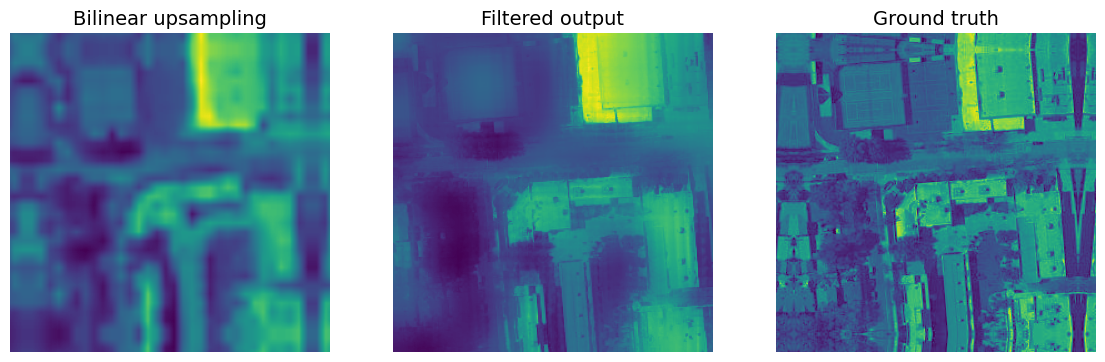

In [2]:
image_path = "/data/NWPU-RESISC45/tennis_court/tennis_court_130.jpg"
image = torchvision.io.read_image(image_path)
transform = v2.Compose([
    #v2.Resize(256),
    #v2.CenterCrop((224, 224)),
    v2.Grayscale(1)
])
image = transform(image)
width = height = image.shape[-1]
nC = image.shape[0]
small = 32
src = v2.Resize(small)(image)

from concurrent.futures import ProcessPoolExecutor

reference = np.array(image.permute(1,2,0))/255.
source_image_upsampled = v2.Resize(width)(src)/255.
source_upsampled = np.array(source_image_upsampled.permute(1,2,0))

scale = small / width
radius = 2
diameter = 2 * radius + 1
step = int(np.ceil(1 / scale))
padding = radius * step
sigma_spatial = 2.5
sigma_range = np.std(reference)

reference = np.pad(reference, ((padding, padding), (padding, padding), (0, 0)), 'symmetric').astype(np.float32)
source_upsampled = np.pad(source_upsampled, ((padding, padding), (padding, padding), (0, 0)), 'symmetric').astype(np.float32)

# Spatial Gaussian function.
x, y = np.meshgrid(np.arange(diameter) - radius, np.arange(diameter) - radius)
kernel_spatial = np.exp(-1.0 * (x**2 + y**2) /  (2 * sigma_spatial**2))
kernel_spatial = np.repeat(kernel_spatial, nC).reshape(-1, nC)

def process_row(y):
    result = np.zeros((width, nC))
    y += padding
    for x in range(padding, reference.shape[1] - padding):
        I_p = reference[y, x]
        #print(y,x,I_p)
        patch_reference = reference[y - padding:y + padding + 1:step, x - padding:x + padding + 1:step].reshape(-1, nC)
        patch_source_upsampled = source_upsampled[y - padding:y + padding + 1:step, x - padding:x + padding + 1:step].reshape(-1, nC)
        kernel_range = np.exp(-1.0 * (patch_reference - I_p)**2 / (2 * sigma_range**2))
        weight = kernel_range * kernel_spatial
        k_p = weight.sum(axis=0)
        if x-padding==30 and y==30+padding:
            print(weight.shape)
            print(k_p)
        result[x - padding] = np.sum(weight * patch_source_upsampled, axis=0) / k_p
    return result

executor = ProcessPoolExecutor()
start = time.time()
result = []
for y in range(height):
    res = process_row(y)
    result.append(res)
    #break
jbu = np.array(result)
#result = executor.map(process_row, range(height))
#jbu = np.array(list(result))
end = time.time()
print("Runtime forward pass: {} s".format(end - start))
executor.shutdown(True)

# Visual results.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,6))
print(jbu.shape)
axes[0].imshow(source_upsampled)
axes[0].set_title('Bilinear upsampling', fontsize=14)
axes[0].axis('off')
axes[1].imshow(jbu)
axes[1].set_title('Filtered output', fontsize=14)
axes[1].axis('off')
axes[2].imshow(reference)
axes[2].set_title('Ground truth', fontsize=14)
axes[2].axis('off')
plt.show()

torch.Size([1, 256, 256])


/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([25, 1, 1])
bili_up torch.Size([1, 288, 288])
torch.Size([25, 256, 256])
tensor([0.4824, 0.0693, 0.2220, 0.2470, 0.0836, 0.1919, 0.0769, 0.8891, 0.1645,
        0.4612, 0.0517, 0.0955, 1.0000, 0.1851, 0.3888, 0.1503, 0.0734, 0.2469,
        0.1194, 0.6237, 0.1560, 0.2325, 0.6860, 0.0863, 0.4639],
       device='cuda:0')
torch.Size([256, 256, 25])
torch.Size([1, 1, 25, 256, 256])
torch.Size([1, 1, 256, 256])


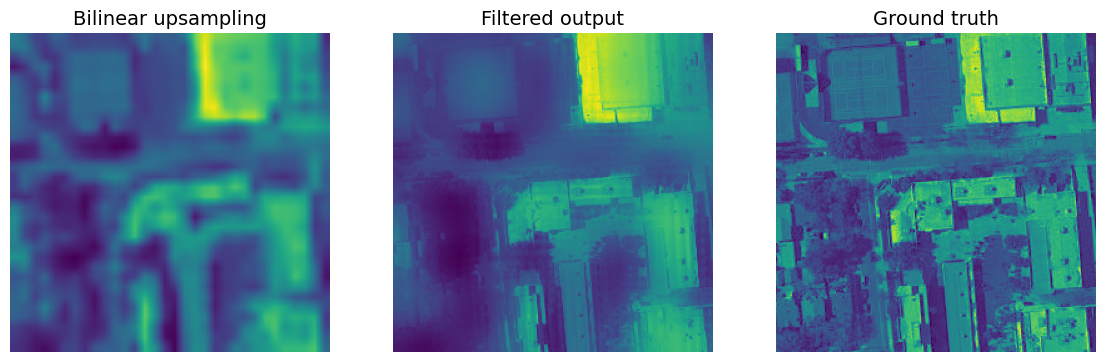

In [3]:
import torch.nn as nn
import torch.nn.functional as F

image_path = "/data/NWPU-RESISC45/tennis_court/tennis_court_130.jpg"
image = torchvision.io.read_image(image_path)
transform = v2.Compose([
    #v2.Resize(256),
    #v2.CenterCrop((224, 224)),
    v2.Grayscale(1),
    v2.ToDtype(torch.float32, scale=True)
])
image = transform(image)
print(image.shape)
width = height = image.shape[-1]
nC = image.shape[0]
small = 32
src = v2.Resize(small)(image)

bili_up = v2.Resize(width)(src)

scale = small / width
radius = 2
diameter = 2 * radius + 1
step = int(np.ceil(1 / scale))
padding = radius * step
sigma_spatial = 2.5
sigma_range = torch.std(image)

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

s = torch.arange(diameter) - radius
x, y = torch.meshgrid(s,s)
patch = torch.cat([x.unsqueeze(0), y.unsqueeze(0)], dim=0).to(dev)
spatial_kernel = torch.exp(- patch.square().sum(0) / (2 * sigma_spatial ** 2)).reshape(diameter * diameter, 1, 1)
print(spatial_kernel.shape)

image_padded = F.pad(image, pad=[padding] * 4, mode='reflect')
bili_up_padded = F.pad(bili_up, pad=[padding] * 4, mode='reflect')
print('bili_up', bili_up_padded.shape)

kernels = torch.nn.Unfold(kernel_size=diameter, dilation=step)(image_padded).to(dev)
kernels = kernels.reshape((diameter * diameter, height, width))
range_kernel = torch.exp(- (kernels - image.to(dev)).square() / (2 * sigma_range ** 2))
print(range_kernel.shape)

combined_kernel = range_kernel * spatial_kernel
print(combined_kernel[:,30,30])
k_p = combined_kernel.sum(0, keepdim=True).clamp(1e-7)
combined_kernel /= k_p
combined_kernel = combined_kernel.permute(1,2,0)#.reshape(height, width, diameter, diameter)
print(combined_kernel.shape)



patches = torch.nn.Unfold(kernel_size=diameter, dilation=step)(bili_up_padded.unsqueeze(1)).to(dev)
patches = patches.view(1,1,diameter*diameter,height,width)
print(patches.shape)

batch_kernel = combined_kernel.unsqueeze(0)
pred = torch.einsum('bhwf,bcfhw->bchw', batch_kernel, patches).detach().cpu()
print(pred.shape)

# Visual results.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,6))
axes[0].imshow(bili_up.permute(1,2,0).numpy())
axes[0].set_title('Bilinear upsampling', fontsize=14)
axes[0].axis('off')
axes[1].imshow(pred[0].permute(1,2,0).numpy())
axes[1].set_title('Filtered output', fontsize=14)
axes[1].axis('off')
axes[2].imshow(image.permute(1,2,0).numpy())
axes[2].set_title('Ground truth', fontsize=14)
axes[2].axis('off')
plt.show()

tensor(0.1859)
spatial : torch.Size([1, 25, 1, 1])
torch.Size([1, 25, 65536])
tensor([0.9734, 0.9780, 0.9821, 0.9780, 0.9734, 0.9892, 0.9964, 0.9991, 0.9964,
        0.9892, 0.9892, 0.9980, 1.0000, 0.9980, 0.9892, 0.9892, 0.9964, 0.9991,
        0.9964, 0.9892, 0.9734, 0.9780, 0.9821, 0.9780, 0.9734],
       device='cuda:0', grad_fn=<SelectBackward0>)
range : torch.Size([1, 25, 256, 256])
combined torch.Size([1, 25, 256, 256])
Runtime forward pass: 0.17648744583129883 s


/tmp/ipykernel_1020856/2485466730.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigma_range = nn.Parameter(torch.tensor(sigma_r))


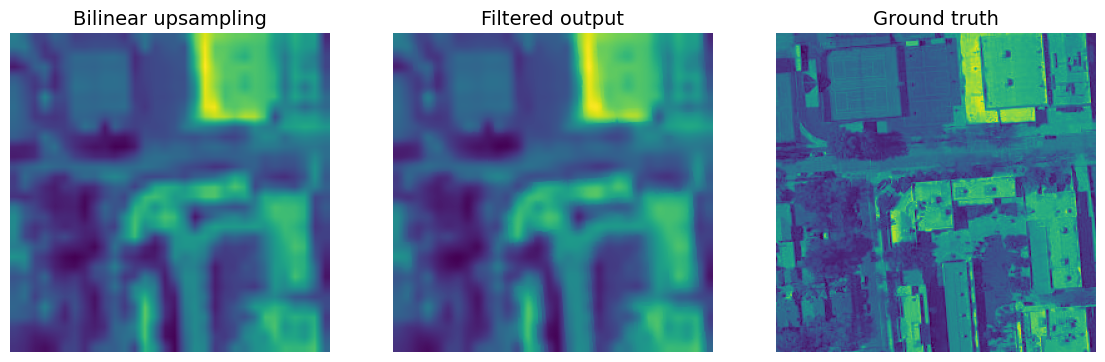

In [5]:
import torch.nn as nn
import torch.nn.functional as F

image_path = "/data/NWPU-RESISC45/tennis_court/tennis_court_130.jpg"
image = torchvision.io.read_image(image_path)
transform = v2.Compose([
    #v2.Resize(256),
    #v2.CenterCrop((224, 224)),
    v2.Grayscale(1),
    v2.ToDtype(torch.float32, scale=True)
])
image = transform(image)
width = height = image.shape[-1]
nC = image.shape[0]
small = 32
src = v2.Resize(small)(image)

source_image_upsampled = v2.Resize(width)(src)

def adaptive_conv_py_simple(input, filters):
    b, c, h1, w1 = input.shape
    b, h2, w2, f1, f2 = filters.shape
    assert f1 == f2
    kernel_size = f1

    t_filters = filters.reshape(b, h2, w2, f1 * f2)

    patches = torch.nn.Unfold(kernel_size)(input) \
        .view((b, c, f1 * f2, h2, w2))

    return torch.einsum('bhwf,bcfhw->bchw', t_filters, patches)


class JBULearnedRange(torch.nn.Module):

    def __init__(self, guidance_dim, feat_dim, key_dim, scale=2, radius=3, sigma_r=1., sigma_s=1.):
        super().__init__()
        self.scale = scale
        self.radius = radius
        self.padding = scale * radius
        self.diameter = self.radius * 2 + 1
        self.guidance_dim = guidance_dim
        self.key_dim = key_dim
        self.feat_dim = feat_dim
        self.sigma_range = nn.Parameter(torch.tensor(sigma_r))
        self.sigma_spatial = nn.Parameter(torch.tensor(sigma_s))

    def get_range_kernel(self, x):
        GB, GC, GH, GW = x.shape
        x_padded = F.pad(x, pad=[self.radius] * 4, mode='reflect')#[...,::self.scale, ::self.scale]
        queries = torch.nn.Unfold(self.diameter)(x_padded)
        print(queries.shape)
        queries = queries.reshape((GB, GC, self.diameter * self.diameter, GH, GW)).squeeze(1)
        res = torch.exp(- (queries - x).square() / (2 * self.sigma_range ** 2))
        print(res[0,:,0,0])
        print('range :', res.shape)
        return res
        
    def get_spatial_kernel(self, device):
        s = torch.arange(self.diameter) - self.radius
        x, y = torch.meshgrid(s,s)
        patch = torch.cat([x.unsqueeze(0), y.unsqueeze(0)], dim=0).to(device)
        res = torch.exp(- patch.square().sum(0) / (2 * self.sigma_spatial ** 2)) \
            .reshape(1, self.diameter * self.diameter, 1, 1)
        print('spatial :', res.shape)
        return res

    def forward(self, source, guidance):
        
        GB, GC, GH, GW = guidance.shape
        SB, SC, SH, SQ = source.shape
        assert (SB == GB)

        spatial_kernel = self.get_spatial_kernel(source.device)
        range_kernel = self.get_range_kernel(guidance)

        combined_kernel = range_kernel * spatial_kernel
        combined_kernel /= combined_kernel.sum(1, keepdim=True).clamp(1e-7)
        print('combined', combined_kernel.shape)

        combined_kernel = combined_kernel.permute(0, 2, 3, 1) \
            .reshape(GB, GH, GW, self.diameter, self.diameter)

        hr_source = torch.nn.Upsample((GH, GW), mode='bilinear', align_corners=False)(source)
        hr_source_padded = F.pad(hr_source, pad=[self.radius] * 4, mode='reflect')

        # (B C, H+Pad, W+Pad) x (B, H, W, KH, KW) -> BCHW
        #result = AdaptiveConv.apply(hr_source_padded, combined_kernel)
        result = adaptive_conv_py_simple(hr_source_padded, combined_kernel)
        return result

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigma_r = torch.std(image)
print(sigma_r)
sigma_s = 2.5
jbu_layer = JBULearnedRange(guidance_dim=1, feat_dim=1, key_dim=1, scale=8, radius=2, sigma_r=sigma_r, sigma_s=sigma_s).to(dev)
# Forward pass.
start = time.time()
prediction = jbu_layer(src.unsqueeze(0).to(dev), image.unsqueeze(0).to(dev)).squeeze(0).detach().cpu()
end = time.time()
print("Runtime forward pass: {} s".format(end - start))

# Visual results.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,6))
axes[0].imshow(source_image_upsampled.permute(1,2,0).numpy())
axes[0].set_title('Bilinear upsampling', fontsize=14)
axes[0].axis('off')
axes[1].imshow(prediction.permute(1,2,0).numpy())
axes[1].set_title('Filtered output', fontsize=14)
axes[1].axis('off')
axes[2].imshow(image.permute(1,2,0).numpy())
axes[2].set_title('Ground truth', fontsize=14)
axes[2].axis('off')
plt.show()